In [1]:
%load_ext autoreload
%autoreload 2

## Training Transformer

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split, get_sample_weights, get_eval_set
from src.preprocessing import preprocess_data
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict
import transformers
from peft import get_peft_model, LoraConfig, TaskType
import re
from bert_score import BERTScorer
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.tokenize import word_tokenize
from langdetect import detect

from transformers import BitsAndBytesConfig

tqdm.pandas()

In [3]:


def get_first_texts(x, max_size = 100):
    size = x.apply(lambda x: len(x.split(" ")))\
        .sort_values()
    
    x = x.reindex_like(size)
    mask = size < max_size
    # mask = x.str.lower().str.contains("goal")

    return "\n".join(x[mask])
    # return x[mask].tolist()

In [4]:
train_data, test_data = train_test_split()
def get_samples(indices, frac = 1, df = None):
    all_df = []

    if df is None:
        for id in indices:
            temp_df = train_data[id]

            
            
            all_df.append(temp_df.dropna().sample(frac=frac))

            
        return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({
            "Tweet":    get_first_texts,
            "EventType": np.mean,
            "ID": len
        })
    
    else: 
        return (df).groupby(["MatchID", "PeriodID"]).agg({
            "Tweet":    get_first_texts,
            "EventType": np.mean,
            "ID": len
        })

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:05<00:00,  3.02it/s]


In [6]:
x = pd.concat(train_data)

In [8]:
possible_indices = set(train_data.keys())

In [9]:
test_indices = list(np.random.choice(list(possible_indices), size=3, replace = False,))
# test_indices = [13,1,18]
all_train_indices = list(possible_indices.difference(set(test_indices)))
# val_indices = [5,4,12]
val_indices = list(np.random.choice(all_train_indices, 3, replace=False))
train_indices = list(set(all_train_indices).difference(set(val_indices)))


train_df = get_samples(train_indices,)
# train_df = get_samples(train_indices, df = train)
test_df = get_samples(test_indices)
val_df = get_samples(val_indices)

/tmp/ipykernel_822449/1023686446.py:14: FutureWarning: The provided callable <function mean at 0x7fadd83edc60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.concat(all_df).groupby(["MatchID", "PeriodID"]).agg({


In [10]:
def remove_hashtag_links(df):

    df['Tweet'] = df['Tweet'].str.replace(r"#\w+", "", regex=True)

    # Remove links
    df['Tweet'] = df['Tweet'].str.replace(r"http\S+|www\S+", "", regex=True)

    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE
    )
    # df['Tweet'] = df['Tweet'].str.replace(emoji_pattern, "", regex=True)
    # df['Tweet'] = df['Tweet'].str.strip()

    return df

In [11]:
train_df = remove_hashtag_links(train_df)
test_df = remove_hashtag_links(test_df)
val_df = remove_hashtag_links(val_df)

In [12]:
class EmbeddingMLPClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout_rate=0.4):
        super(EmbeddingMLPClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 2)  # Binary classification (logits for two classes)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        x = torch.mean(x, dim=1)  # Shape: (batch_size, embedding_dim)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)  # Output logits for two classes
        return x

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = '/Data')

train_labels = torch.tensor(train_df['EventType'].tolist(), dtype=torch.float32)
val_labels = torch.tensor(val_df['EventType'].tolist(), dtype=torch.float32)

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
device = "cuda"
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return tokenizer(self.texts[idx],return_tensors="pt").to(device)['input_ids'], self.labels[idx].to(device)



In [15]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    # Pad input sequences
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)  # Stack labels
    return padded_texts, labels

In [16]:
train_dataset = TextDataset(train_df['Tweet'].tolist(), train_labels)
val_dataset = TextDataset(val_df['Tweet'].tolist(), val_labels)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn= collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn= collate_fn)

In [21]:
embedding_dim = 25
hidden_dim = 32
vocab_size = tokenizer.vocab_size  # Use tokenizer's vocab size
model = EmbeddingMLPClassifier(vocab_size, embedding_dim, dropout_rate=0.6)
model.to(device)

class_weight = torch.Tensor([0.4, 0.6]).to(device)
criterion = nn.CrossEntropyLoss(class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.1)

# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100)

best_model = None
best_acc = 0


# Training with Validation
num_epochs = 150

val_accs = []
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0

    for batch_inputs, batch_labels in tqdm(train_loader):
        # print(batch_inputs.shape)
        outputs = model(batch_inputs.squeeze(dim = 1))
        loss = criterion(outputs, batch_labels.to(torch.long))
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            outputs = model(batch_inputs.squeeze(dim = 1))
            loss = criterion(outputs, batch_labels.to(torch.long))
            val_loss += loss.item()
            
            # Collect predictions and targets for accuracy calculation
            val_preds.extend((outputs[:,1] >= 0.5).int().tolist())
            val_targets.extend(batch_labels.int().tolist())
    
    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)
    clear_output()
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    val_accs.append(val_accuracy)
    print(confusion_matrix(val_targets, val_preds))

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = deepcopy(model)

Validation Loss: 0.6932, Validation Accuracy: 0.4897
[[191   0]
 [199   0]]


 22%|██▏       | 304/1357 [00:08<00:30, 34.44it/s]


KeyboardInterrupt: 

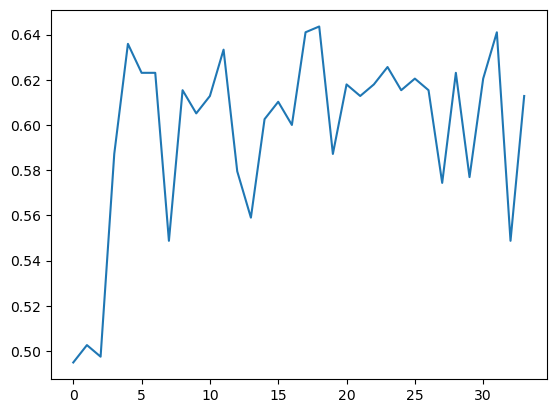

In [20]:
plt.plot(val_accs)

In [78]:
test_labels = torch.tensor(test_df['EventType'].tolist(), dtype=torch.float32)
test_dataset = TextDataset(test_df['Tweet'].tolist(), test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn= collate_fn)

In [79]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

763102

In [ ]:
test_preds = []
test_targets = []

with torch.no_grad():
    for batch_inputs, batch_labels in tqdm(test_loader):
        outputs = best_model(batch_inputs.squeeze(dim = 1))
        loss = criterion(outputs, batch_labels.to(torch.long))
        val_loss += loss.item()
        
        # Collect predictions and targets for accuracy calculation
        test_preds.extend((outputs[:,1] >= 0.5).int().tolist())
        test_targets.extend(batch_labels.int().tolist())

val_loss /= len(val_loader)
val_accuracy = accuracy_score(test_targets, test_preds)
conf_matrix = confusion_matrix(test_targets, test_preds)

100%|██████████| 430/430 [00:09<00:00, 45.34it/s]


In [83]:
val_accuracy

0.6930232558139535

In [ ]:
conf_matrix

array([[111,  76],
       [ 56, 187]])

In [90]:
eval_df

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...,...
628693,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...
628694,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...
628695,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully..."
628696,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...


In [151]:
eval_df = get_eval_set()
eval_df = preprocess_data(eval_df)

eval_df = eval_df.groupby(["MatchID", "PeriodID"]).agg({
    "Tweet":    get_first_texts,
    "ID": lambda x: x.iloc[0]
})

eval_df = remove_hashtag_links(eval_df)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


In [152]:


# eval_labels = torch.tensor(eval_df['EventType'].tolist(), dtype=torch.float32)
eval_dataset = TextDataset(eval_df['Tweet'].tolist(), torch.zeros(len(eval_df)))
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False, collate_fn= collate_fn)

In [153]:
eval_preds = []
eval_targets = []

with torch.no_grad():
    for batch_inputs, batch_labels in tqdm(eval_loader):
        outputs = best_model(batch_inputs.squeeze(dim = 1))
        
        # Collect predictions and targets for accuracy calculation
        eval_preds.extend((outputs[:,1] >= 0.5).int().tolist())
        eval_targets.extend(batch_labels.int().tolist())

  0%|          | 0/516 [00:00<?, ?it/s]

100%|██████████| 516/516 [00:08<00:00, 59.07it/s] 


In [154]:
eval_df['EventType'] = eval_preds

In [134]:
sample = pd.read_csv("sub-event-detection-in-twitter-streams/challenge_data/dummy_predictions.csv", index_col=0)

In [155]:
sample.index

Index(['6_0', '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '6_9',
       ...
       '16_120', '16_121', '16_122', '16_123', '16_124', '16_125', '16_126',
       '16_127', '16_128', '16_129'],
      dtype='object', name='ID', length=516)

In [156]:
# eval_df.set_index("ID")[['EventType']].reindex(index = sample.index).to_csv("predictions_2.csv")

In [157]:
eval_df.set_index("ID")[['EventType']].to_csv("predictions_2.csv")

In [158]:
eval_df['EventType'].value_counts(normalize=True)

EventType
1    0.856589
0    0.143411
Name: proportion, dtype: float64